In [1]:
import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
def make_generator_network(input_size=20, num_hidden_layers=1, num_hidden_units=100, num_output_units=784):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_g{i}', nn.Linear(input_size, num_hidden_units, bias=False))
        model.add_module(f'relu_g{i}', nn.LeakyReLU())
        input_size = num_hidden_units

    model.add_module(f'fc_g{num_hidden_layers}', nn.Linear(input_size, num_output_units))
    model.add_module(f'tanh_g', nn.Tanh())
    return model

def make_discriminator_network(input_size, num_hidden_layers=1, num_hidden_units=100, num_output_units=1):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_d{i}', nn.Linear(input_size, num_hidden_units, bias=False))
        model.add_module(f'relu_d{i}', nn.LeakyReLU())
        model.add_module('dropout', nn.Dropout(p=0.5))
        input_size = num_hidden_units

    model.add_module(f'fc_d{num_hidden_layers}', nn.Linear(input_size, num_output_units))
    model.add_module('sigmoid', nn.Sigmoid())

    return model

In [3]:
image_size = (28, 28)
z_size = 20
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

gen_model = make_generator_network(input_size=z_size, num_hidden_layers=gen_hidden_layers, num_hidden_units=gen_hidden_size, num_output_units=np.prod(image_size))
disc_model = make_discriminator_network(input_size=np.prod(image_size), num_hidden_layers=disc_hidden_layers, num_hidden_units=disc_hidden_size)

In [4]:
gen_model, disc_model

(Sequential(
   (fc_g0): Linear(in_features=20, out_features=100, bias=False)
   (relu_g0): LeakyReLU(negative_slope=0.01)
   (fc_g1): Linear(in_features=100, out_features=784, bias=True)
   (tanh_g): Tanh()
 ),
 Sequential(
   (fc_d0): Linear(in_features=784, out_features=100, bias=False)
   (relu_d0): LeakyReLU(negative_slope=0.01)
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_d1): Linear(in_features=100, out_features=1, bias=True)
   (sigmoid): Sigmoid()
 ))

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))])
mnist_dataset = torchvision.datasets.MNIST(root='./', train=True, transform=transform, download=True)
example, label = next(iter(mnist_dataset))

example.min(), example.max(), example.shape

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.68MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.10MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.58MB/s]


(tensor(-1.), tensor(1.), torch.Size([1, 28, 28]))

In [6]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size) * 2 - 1
    elif mode_z == 'normal':
        input_z = torch.rand(batch_size, z_size)

    return input_z

In [7]:
batch_size = 32
dataloader = DataLoader(mnist_dataset, batch_size, shuffle=False)
input_real, label = next(iter(dataloader))
input_real = input_real.view(batch_size, -1)
mode_z = 'uniform'
input_z = create_noise(batch_size, z_size, mode_z)

input_z.shape, input_real.shape

(torch.Size([32, 20]), torch.Size([32, 784]))

In [8]:
g_output = gen_model(input_z)
g_output.shape

torch.Size([32, 784])

In [9]:
d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)

d_proba_real.shape, d_proba_fake.shape

(torch.Size([32, 1]), torch.Size([32, 1]))

In [10]:
loss_fn = nn.BCELoss()
g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)

g_loss

tensor(0.6753, grad_fn=<BinaryCrossEntropyBackward0>)

In [11]:
d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)
d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

d_loss_real, d_loss_fake

(tensor(0.6988, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.7116, grad_fn=<BinaryCrossEntropyBackward0>))

In [12]:
batch_size = 64
device = torch.device('cuda:0')
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
gen_model = make_generator_network(input_size=z_size, num_hidden_layers=gen_hidden_layers, num_hidden_units=gen_hidden_size, num_output_units=np.prod(image_size)).to(device)
disc_model = make_discriminator_network(input_size=np.prod(image_size), num_hidden_layers=disc_hidden_layers, num_hidden_units=disc_hidden_size).to(device)
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

In [18]:
def d_train(x):
    disc_model.zero_grad()
    batch_size = x.size(0)

    x = x.view(batch_size, -1).to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)
    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

def g_train(x):
    gen_model.zero_grad()
    batch_size = x.size(0)

    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [14]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images + 1) / 2.0

In [19]:
epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []
num_epochs = 100

for epoch in range(1, num_epochs):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))
        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())

    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())
    print(f'Epoch {epoch} | Avg Losses > G/D {all_g_losses[-1]}/{all_d_losses[-1]} [D-real: {all_d_real[-1]} D-Fake: {all_d_fake[-1]}]')
    epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 1 | Avg Losses > G/D 0.9066777229309082/0.9547246694564819 [D-real: 0.7786555290222168 D-Fake: 0.4790550470352173]
Epoch 2 | Avg Losses > G/D 0.8626047968864441/1.2162060737609863 [D-real: 0.582763135433197 D-Fake: 0.4577804207801819]
Epoch 3 | Avg Losses > G/D 1.0648772716522217/1.1229009628295898 [D-real: 0.6149855256080627 D-Fake: 0.4108385145664215]
Epoch 4 | Avg Losses > G/D 1.0446360111236572/1.1023871898651123 [D-real: 0.6168270111083984 D-Fake: 0.3944796025753021]
Epoch 5 | Avg Losses > G/D 1.03361177444458/1.1514973640441895 [D-real: 0.596461296081543 D-Fake: 0.3955390751361847]
Epoch 6 | Avg Losses > G/D 0.9478790760040283/1.2221763134002686 [D-real: 0.5713548064231873 D-Fake: 0.424000084400177]
Epoch 7 | Avg Losses > G/D 1.1834497451782227/1.0627734661102295 [D-real: 0.62986159324646 D-Fake: 0.3602249324321747]
Epoch 8 | Avg Losses > G/D 1.1147263050079346/1.0999846458435059 [D-real: 0.6223623156547546 D-Fake: 0.37827661633491516]
Epoch 9 | Avg Losses > G/D 1.291440963

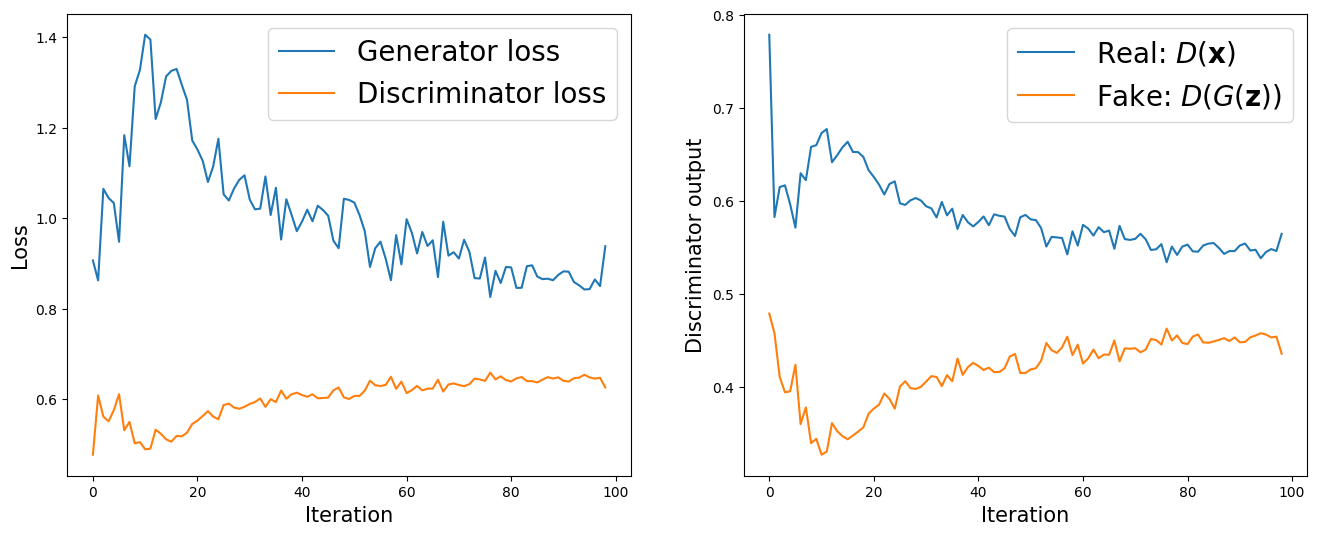

In [20]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss / 2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)
plt.show()

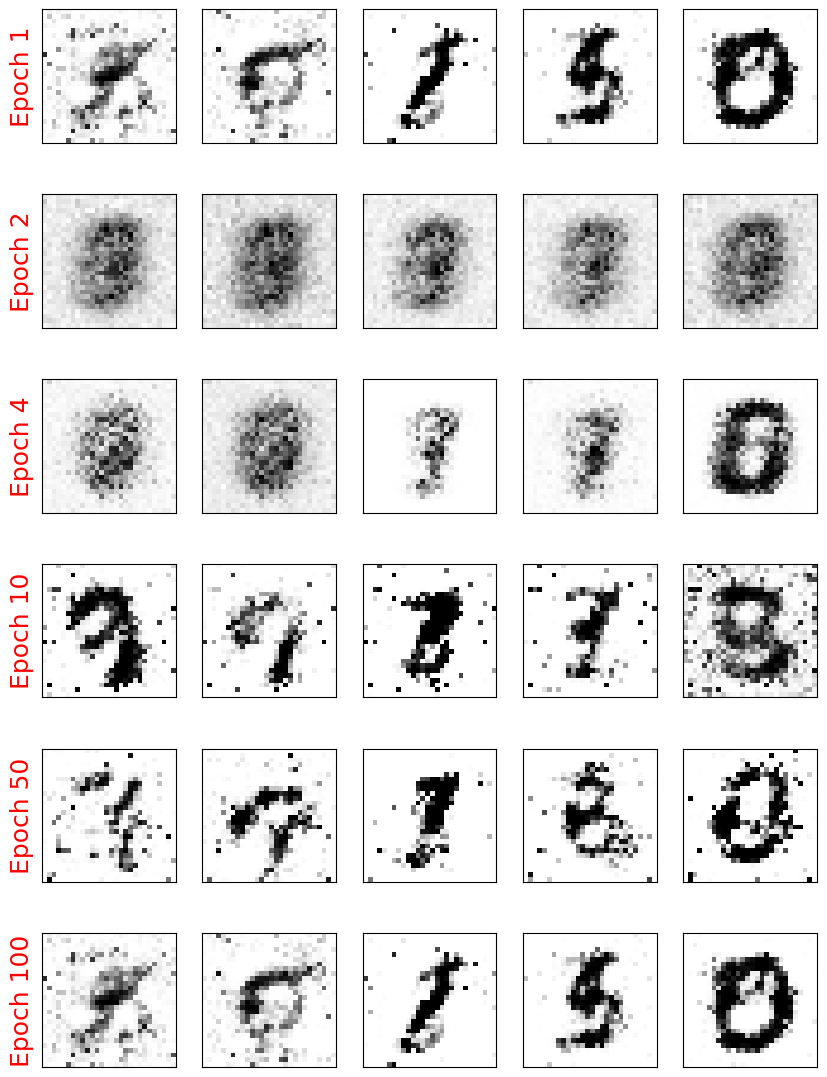

In [23]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i, e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i * 5 + j + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(-0.06, 0.5, f'Epoch {e}', rotation=90, size=18, color='red', horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
        image = epoch_samples[e-2][j]
        ax.imshow(image, cmap='gray_r')

plt.show()